In [225]:
!pwd
!ls


/content
penguins_preprocessed.csv  sample_data


In [226]:
# 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

In [227]:
df = pd.read_csv('/content/penguins_preprocessed.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   calorie requirement     344 non-null    float64
 1   average sleep duration  344 non-null    float64
 2   bill_length_mm          344 non-null    float64
 3   bill_depth_mm           344 non-null    float64
 4   flipper_length_mm       344 non-null    float64
 5   body_mass_g             344 non-null    float64
 6   year                    344 non-null    float64
 7   species_chinstrap       344 non-null    bool   
 8   species_gentoo          344 non-null    bool   
 9   species_nan             344 non-null    bool   
 10  island_dream            344 non-null    bool   
 11  island_nan              344 non-null    bool   
 12  island_torgersen        344 non-null    bool   
 13  gender_male             344 non-null    bool   
 14  gender_nan              344 non-null    bo

In [228]:
# 2
target = ~(df['gender_nan']) # Here we are targeting an array of boolen values.
X = np.array(df.loc[target].drop(['gender_male', 'gender_nan'], axis=1).values, dtype=np.float64)
Y = np.array(df.loc[target, 'gender_male'].astype(int).values, dtype=np.float64).reshape(-1, 1)
# For 'X' rows with valid gender are considered. For 'Y' 'gender_male' row is selected (non missing rows)


In [229]:
# 3
unique, counts = np.unique(Y, return_counts=True)
class_counts = dict(zip(unique, counts))
print('Class counts:', class_counts)
# It returns 2 arrays i.e unique and count

Class counts: {np.float64(0.0): np.int64(162), np.float64(1.0): np.int64(165)}


In [230]:
N = X.shape[0]
np.random.seed(42)
indices = np.random.permutation(N)
train_size = ceil(N * 0.8)
train_idx = indices[:train_size]
test_idx = indices[train_size:]
# the total no of rows are counted and random seeding is doone. 80% of the data for training.

X_train = X[train_idx]
y_train = Y[train_idx]
X_test = X[test_idx]
y_test = Y[test_idx]

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
# Split train/test in the ratio of 4:1

X_train shape: (262, 13)
y_train shape: (262, 1)
X_test shape: (65, 13)
y_test shape: (65, 1)


In [231]:
# def sigmoid(z):
#     return 1 / (1 + np.exp(-z))

# def logistic_loss(y, y_pred):
#     eps = 1e-8
#     return -np.mean(y * np.log(y_pred + eps) + (1 - y) * np.log(1 - y_pred + eps))

class LogitRegression:
    def __init__(self, learning_rate=1e-3, iterations=10000, random_seed=42, weights_init=None):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.losses = []
        self.random_seed = random_seed
        self.weights_init = weights_init
        self.w = None
        self.b = 0

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        np.random.seed(self.random_seed)
        N, d = X.shape
        self.w = np.random.uniform(0, 1, (d, 1)) if self.weights_init is None else self.weights_init
        self.b = 0
        self.losses = []
        for i in range(self.iterations):
            z = X @ self.w + self.b
            y_prediction = self.sigmoid(z)
            loss = -np.mean(y * np.log(y_prediction + 1e-8) + (1 - y) * np.log(1 - y_prediction + 1e-8))
            self.losses.append(loss)
            dw = X.T @ (y_prediction - y) / N
            db = np.mean(y_prediction - y)
            self.w -= self.learning_rate * dw
            self.b -= self.learning_rate * db
        return self

    def predict(self, X):
        return (self.sigmoid(X @ self.w + self.b) > 0.5).astype(int)

In [232]:
configs = [
    {'learning_rate': 5e-3, 'iterations': 100000},
    {'learning_rate': 1e-1, 'iterations': 80000},
    {'learning_rate': 2e-2, 'iterations': 100000},
]
# I have done the hyperparameter setup here.

In [233]:
answer = []
for idx, cfg in enumerate(configs, 1): # configs contains hyperparameters
    model = LogitRegression(**cfg)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = np.mean(y_pred == y_test)
    tp = np.sum((y_test == 1) & (y_pred == 1)) # TP: Model predicts 1 and actual is 1.
    tn = np.sum((y_test == 0) & (y_pred == 0)) # TN: Model predicts 0 and actual is 0.
    fp = np.sum((y_test == 0) & (y_pred == 1)) # FP: Model predicts 1 but actual is 0.
    fn = np.sum((y_test == 1) & (y_pred == 0)) # FN: Model predicts 0 but actual is 1.

    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    # prediction, recall and f1 will store correct positive  values, detect actual positive values and mean of both measures respectively.
    conf_mat = np.array([[tn, fp], [fn, tp]])
    answer.append({
        'config': cfg,
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'conf_mat': conf_mat,
        'losses': model.losses
    })

    print(f"\nSetup {idx}: {cfg}")
    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1: {f1:.3f}")
    print("Confusion Matrix:\n", conf_mat)
# By considering the hyperparameters, LogitRegression model is evaluated.


Setup 1: {'learning_rate': 0.005, 'iterations': 100000}
Accuracy: 0.923
Precision: 0.892
Recall: 0.971
F1: 0.930
Confusion Matrix:
 [[27  4]
 [ 1 33]]

Setup 2: {'learning_rate': 0.1, 'iterations': 80000}
Accuracy: 0.877
Precision: 0.882
Recall: 0.882
F1: 0.882
Confusion Matrix:
 [[27  4]
 [ 4 30]]

Setup 3: {'learning_rate': 0.02, 'iterations': 100000}
Accuracy: 0.908
Precision: 0.889
Recall: 0.941
F1: 0.914
Confusion Matrix:
 [[27  4]
 [ 2 32]]


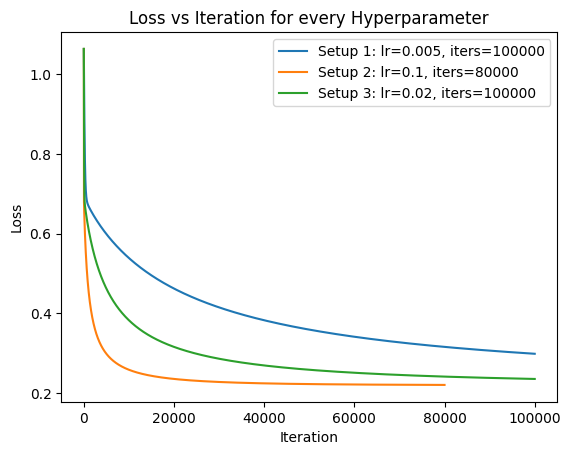

In [234]:
plt.figure()
for idx, r in enumerate(answer, 1):
    plt.plot(r['losses'], label=f'Setup {idx}: lr={r["config"]["learning_rate"]}, iters={r["config"]["iterations"]}')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs Iteration for every Hyperparameter')
plt.legend()
plt.show()

In [235]:
# Training
# w, b = train_logistic_regression(X_train, y_train, lr=0.1, n_iter=1000)

In [236]:
# Prediction
# y_pred = predict(X_test, w, b)
# acc = np.mean(y_pred == y_test)
# print('Test accuracy:', acc)

In [237]:
# df = df.dropna()
# df.shape